<a href="https://colab.research.google.com/github/catarina-moreira/causabilityXAi/blob/master/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demystifying Predictive Black-Box Models: An Interpretable Probabilistic Approach

Catarina Moreira, Yu-Liang Chou, Mythreyi Velmurugan, Renuka Sindhgatta Rajan, Chun Ouyang, Peter Bruza

**Abstract** 


In [ ]:
!pip install pyagrum

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# login into my google drive account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

learning_lib = drive.CreateFile( {'id' : '1wwSN3AIl_dmayKENu5jnc1BRaNPe8BZc'}).GetContentFile("learning.py")


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import PIL
import pydotplus

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
# Install tensorflow
try:
    # tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

In [ ]:
# for reproduciability reasons:
import numpy as np
import pandas as pd
import random as rn
import time

%matplotlib inline

# import auxiliary functions
from learning import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
def generate_rule_stats( class_var, data, VAR=0.1, label="Yes"):
  
  RULE1 = 0
  RULE2 = 0
  RULE3 = 0
  RULE4 = 0

  for instance in data:

      # get instance index
      indx = instance['index']
      
      [bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, 
                                                          class_var, encoder, scaler, clf, PATH + "Whitebox_Model/", DATASET_NAME, 
                                                          variance = VAR)
      ie=gum.LazyPropagation(bn)
      ie.makeInference()
      pos_class = ie.posterior(class_var)

      indx_yes = -1
      indx_no = -1

      if( len(markov_blanket.nodes()) == 1 ):
          RULE2 = RULE2+1
        # gnb.sideBySide(*[bn, inference, markov_blanket  ], captions=[ "Bayesian Network", "Inference", "Markov Blanket" ])
          continue
      
      if (len(bn.variableFromName(class_var).labels()) == 1 ):

          if( bn.variableFromName(class_var).labels()[0] == label):
              if( pos_class[0] >= 0.90 ):
                  RULE1 = RULE1 + 1
  
      if (len(bn.variableFromName(class_var).labels()) == 2 ):
          value_yes = pos_class[1]
          value_no = pos_class[0]

          if( value_yes >= 0.90 ):
              RULE1 = RULE1 + 1

          if( (value_no > value_yes) & (np.round(value_no) == 1) ):
              RULE3 = RULE3 + 1

          if( (value_yes > value_no) & (value_yes < 0.9) ):
              RULE4 = RULE4 + 1
     
  print( [RULE1, RULE2, RULE3, RULE4] )
  print( [RULE1/len(data), RULE2/len(data), RULE3/len(data), RULE4/len(data)] )

## Diabetes Dataset

**Context**
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the 
- number of pregnancies the patient has had, 
- their BMI, 
- insulin level, 
- age,
- glucose,
- blood pressure,
- skin thickness,
- Diabetes pedigree function


### Checking Dataset

In [ ]:
# path to project folder
PATH = "/content/drive/My Drive/Colab Notebooks/DDS/"


In [ ]:
# name of dataset
DATASET_NAME = "diabetes.csv"

# variable containing the class labels in this case the dataset contains:
# 0 - if not diabetes
# 1 - if diabetes
class_var = "Outcome"

# load dataset
dataset_path = PATH + "datasets/" + DATASET_NAME
data = pd.read_csv( dataset_path )


In [ ]:
# features
feature_names = data.drop([class_var], axis=1).columns.to_list()

# check how balanced the classes are
data.groupby(class_var).count()

Pregnancies  Glucose  ...  DiabetesPedigreeFunction  Age
Outcome                        ...                               
0                500      500  ...                       500  500
1                268      268  ...                       268  268

[2 rows x 8 columns]

### Balanced Dataset

In [ ]:
# balance dataset
sampled_data = data.sample(frac=1)
sampled_data = sampled_data[ sampled_data["Outcome"] == 0]
no_data = sampled_data.sample(frac=1)[0:268]

yes_data = data[ data["Outcome"] == 1]

balanced_data = [no_data,yes_data]
balanced_data = pd.concat(balanced_data)

# check how balanced the classes are
balanced_data.groupby(class_var).count()

Pregnancies  Glucose  ...  DiabetesPedigreeFunction  Age
Outcome                        ...                               
0                268      268  ...                       268  268
1                268      268  ...                       268  268

[2 rows x 8 columns]

## Decision Tree - Interpretable Model

In [3]:
# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, indx, exp_type, path ):  

  for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

  samples = instance['scaled_vector']
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  filename = path
  graph.write_png(filename)

  im = PIL.Image.open(filename)
  return im

# EXPORT_DECISION_TREE
# 
def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph

# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  samples = instance['scaled_vector']
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

# GET_DECISION_TREE_FEAT
# 
def get_decision_tree_feat(tree_path):
  features = []
  for feat in tree_path:
    features.append( feat[0].split(" ")[0].replace("<","") )
  
  features.remove("gini")
  features = set(features)
  return features

def getNodeMap( bn ):
  dict_bn = {}
  for n in bn.names():
    dict_bn[bn.idFromName(n)] = n
  return dict_bn

def check_fidelity(bn, markov_blanket, tree_path, verbose = 0 ):
  
  mb_lst = []
  for i in markov_blanket.nodes():
    if getNodeMap(bn)[i] != 'Diabetes?':
      mb_lst.append(getNodeMap(bn)[i])
  
  mb_lst = set(mb_lst)
  dt_lst = get_decision_tree_feat( tree_path )
  if verbose == 1:
    print("Markov Blanket:")
    print(mb_lst )
    print("Decision Tree:")
    print(dt_lst  )

  return mb_lst, dt_lst, (len(mb_lst & dt_lst) / len(dt_lst))*100


In [ ]:
# apply one hot encoder to data
# standardize the input between 0 and 1
X, Y, encoder, scaler = encode_data( data, class_var)

n_features = X.shape[1]
n_classes = len(data[class_var].unique())
 
flag = False  # DO NOT CHANGE! Data has already been generated. 
if flag:
    # save training, test and validation data
    generate_save_training_data( dataset_path, X, Y)
    # load data
    X_train, Y_train, X_test, Y_test, X_validation, Y_validation= load_training_data( dataset_path )
else:
    # load existing training data
    X_train, Y_train, X_test, Y_test, X_validation, Y_validation= load_training_data( dataset_path )
    

In [2]:
# train a Decision Tree classifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

y_true = encoder.inverse_transform( Y_test )
y_pred = encoder.inverse_transform( clf.predict(X_test) )

print("Accuracy:",metrics.accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["No", "Yes"]))


NameError: name 'DecisionTreeClassifier' is not defined

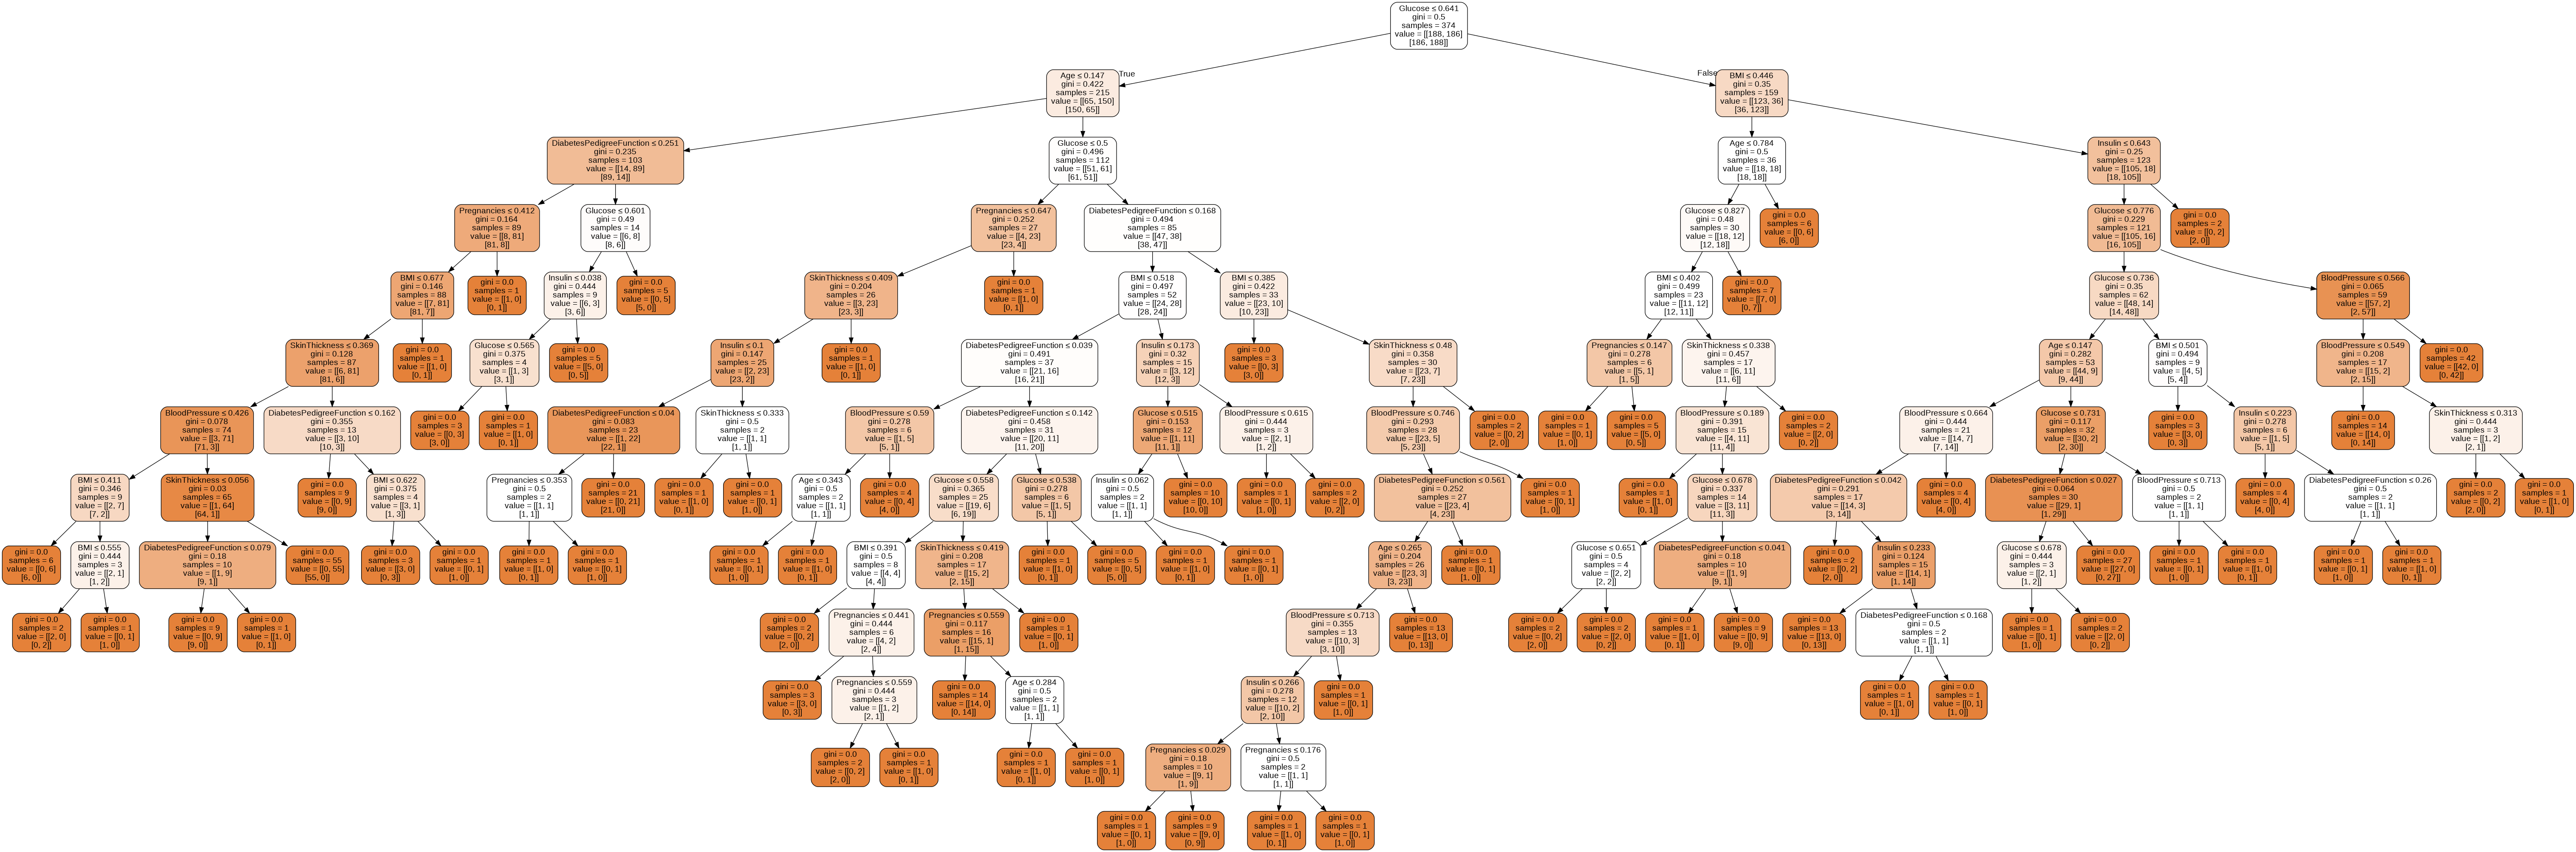

In [ ]:
# export decision tree to a graph
class_names = ["No Diabetes", "Yes Diabetes"]
filepath = PATH + 'Whitebox_Model/explanations/'+ DATASET_NAME.replace(".csv", "")+'/Decision_Tree/Decision_tree_' + DATASET_NAME.replace(".csv", ".png")
graph = export_decision_tree(clf, class_names, DATASET_NAME, filepath) 
Image(graph.create_png())

In [ ]:
# searching for speacific datapoints
local_data_dict = generate_local_predictions( X_test, Y_test, clf, scaler, encoder )

# separates vectors into true positives, true negatives
# false positives and false negatives
true_positives,true_negatives, false_positives, false_negatives = wrap_information( local_data_dict )

# add class variable to the feature list
feature_names.append("Diabetes?")

In [ ]:
# searching for speacific datapoints
local_data_dict_training = generate_local_predictions( X_train, Y_train, clf, scaler, encoder )

# separates vectors into true positives, true negatives
# false positives and false negatives
true_positives_train,true_negatives_train, false_positives_train, false_negatives_train = wrap_information( local_data_dict_training )


In [ ]:
# Generating Explanations with Bayesian Networks 
label_lst = ["No", "Yes"]
class_var = "Diabetes?"

VAR = 0.1

In [ ]:

feature_names_cp = feature_names.copy()
feature_names_cp.append("Diabetes?")
feature_names.remove('Diabetes?')

### Example of True Positive

In [ ]:
exp_type = "true_positives"
INDX = 4
instance = true_positives[INDX]

# get the decision path that explains the instance
tree_path = extract_decision_path(clf, graph, instance )
tree_path

[['<Glucose &le; 0.641', 'value = [[188, 186]', '[186, 188]]>'],
 ['<Age &le; 0.147', 'value = [[65, 150]', '[150, 65]]>'],
 ['<Glucose &le; 0.5', 'value = [[51, 61]', '[61, 51]]>'],
 ['<Pregnancies &le; 0.647', 'value = [[4, 23]', '[23, 4]]>'],
 ['<gini = 0.0', 'value = [[1, 0]', '[0, 1]]>']]

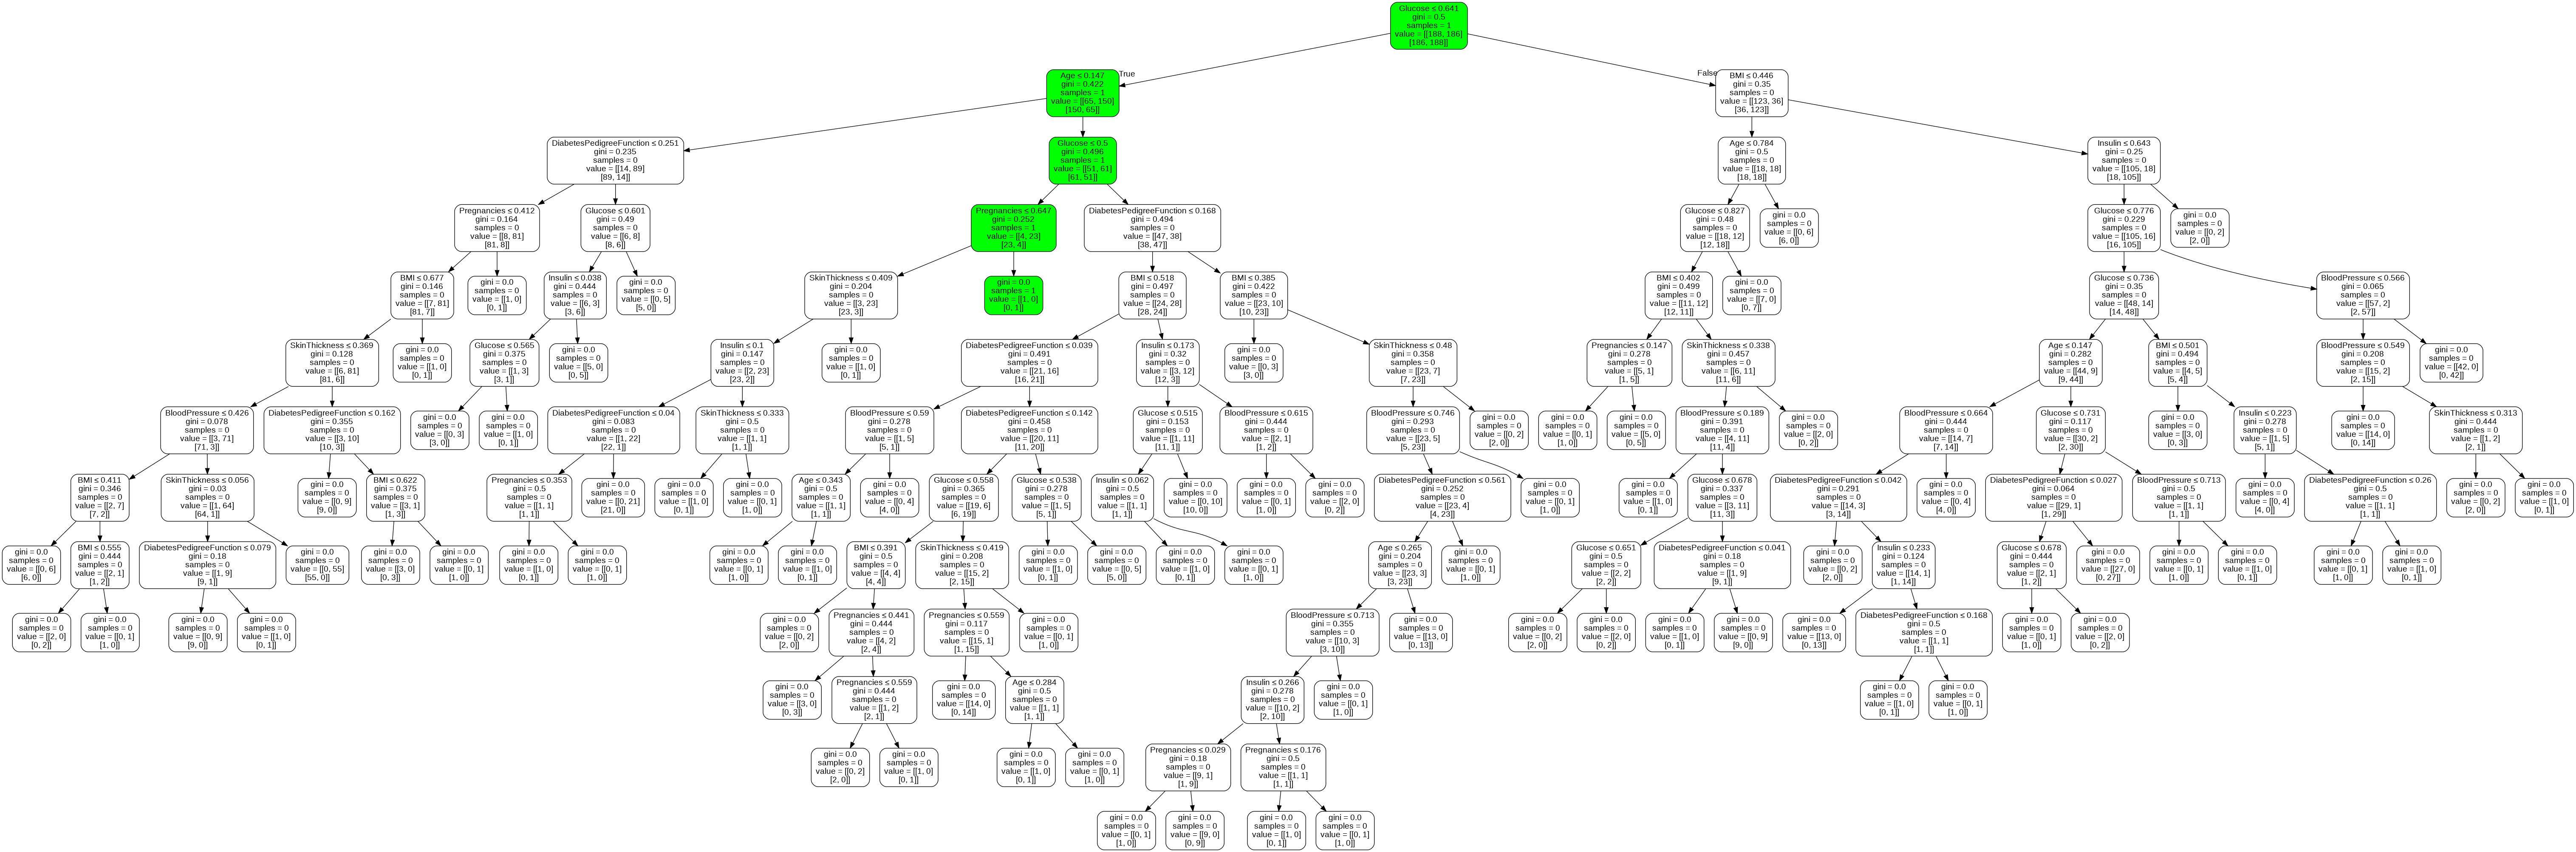

In [ ]:
filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
img = visualize_decision_tree_path( clf, graph, instance, INDX, 'true_positives', filepath)
img

In [ ]:
[bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, class_var, 
                                                                       encoder, scaler, clf,  PATH + 'Whitebox_Model/' , 
                                                                       DATASET_NAME, variance = 0.7)

inference = gnb.getInference(bn, evs={ },targets=feature_names_cp )
gnb.sideBySide(*[inference, markov_blanket, infoBN ], captions=[ "Inference", "Markov Blanket", "Information BN" ])


Selecting Greedy Hill Climbing Algorithm


#### Check fidelity

In [ ]:
 mb_lst, dt_lst,fid = check_fidelity(bn, markov_blanket, tree_path, verbose = 0 )
 print("%.2f%%" %(fid))

75.00%


### Example of True Negative

In [ ]:
exp_type = "true_negatives"
INDX = 1
instance = true_negatives[INDX]

# get the decision path that explains the instance
tree_path = extract_decision_path(clf, graph, instance )
tree_path

[['<Glucose &le; 0.641', 'value = [[188, 186]', '[186, 188]]>'],
 ['<Age &le; 0.147', 'value = [[65, 150]', '[150, 65]]>'],
 ['<DiabetesPedigreeFunction &le; 0.251',
  'samples = 0',
  'value = [[14, 89]',
  '[89, 14]]>'],
 ['<Glucose &le; 0.601', 'samples = 0', 'value = [[6, 8]', '[8, 6]]>'],
 ['<Insulin &le; 0.038', 'samples = 0', 'value = [[6, 3]', '[3, 6]]>'],
 ['<Glucose &le; 0.565', 'samples = 0', 'value = [[1, 3]', '[3, 1]]>'],
 ['<gini = 0.0', 'value = [[0, 3]', '[3, 0]]>']]

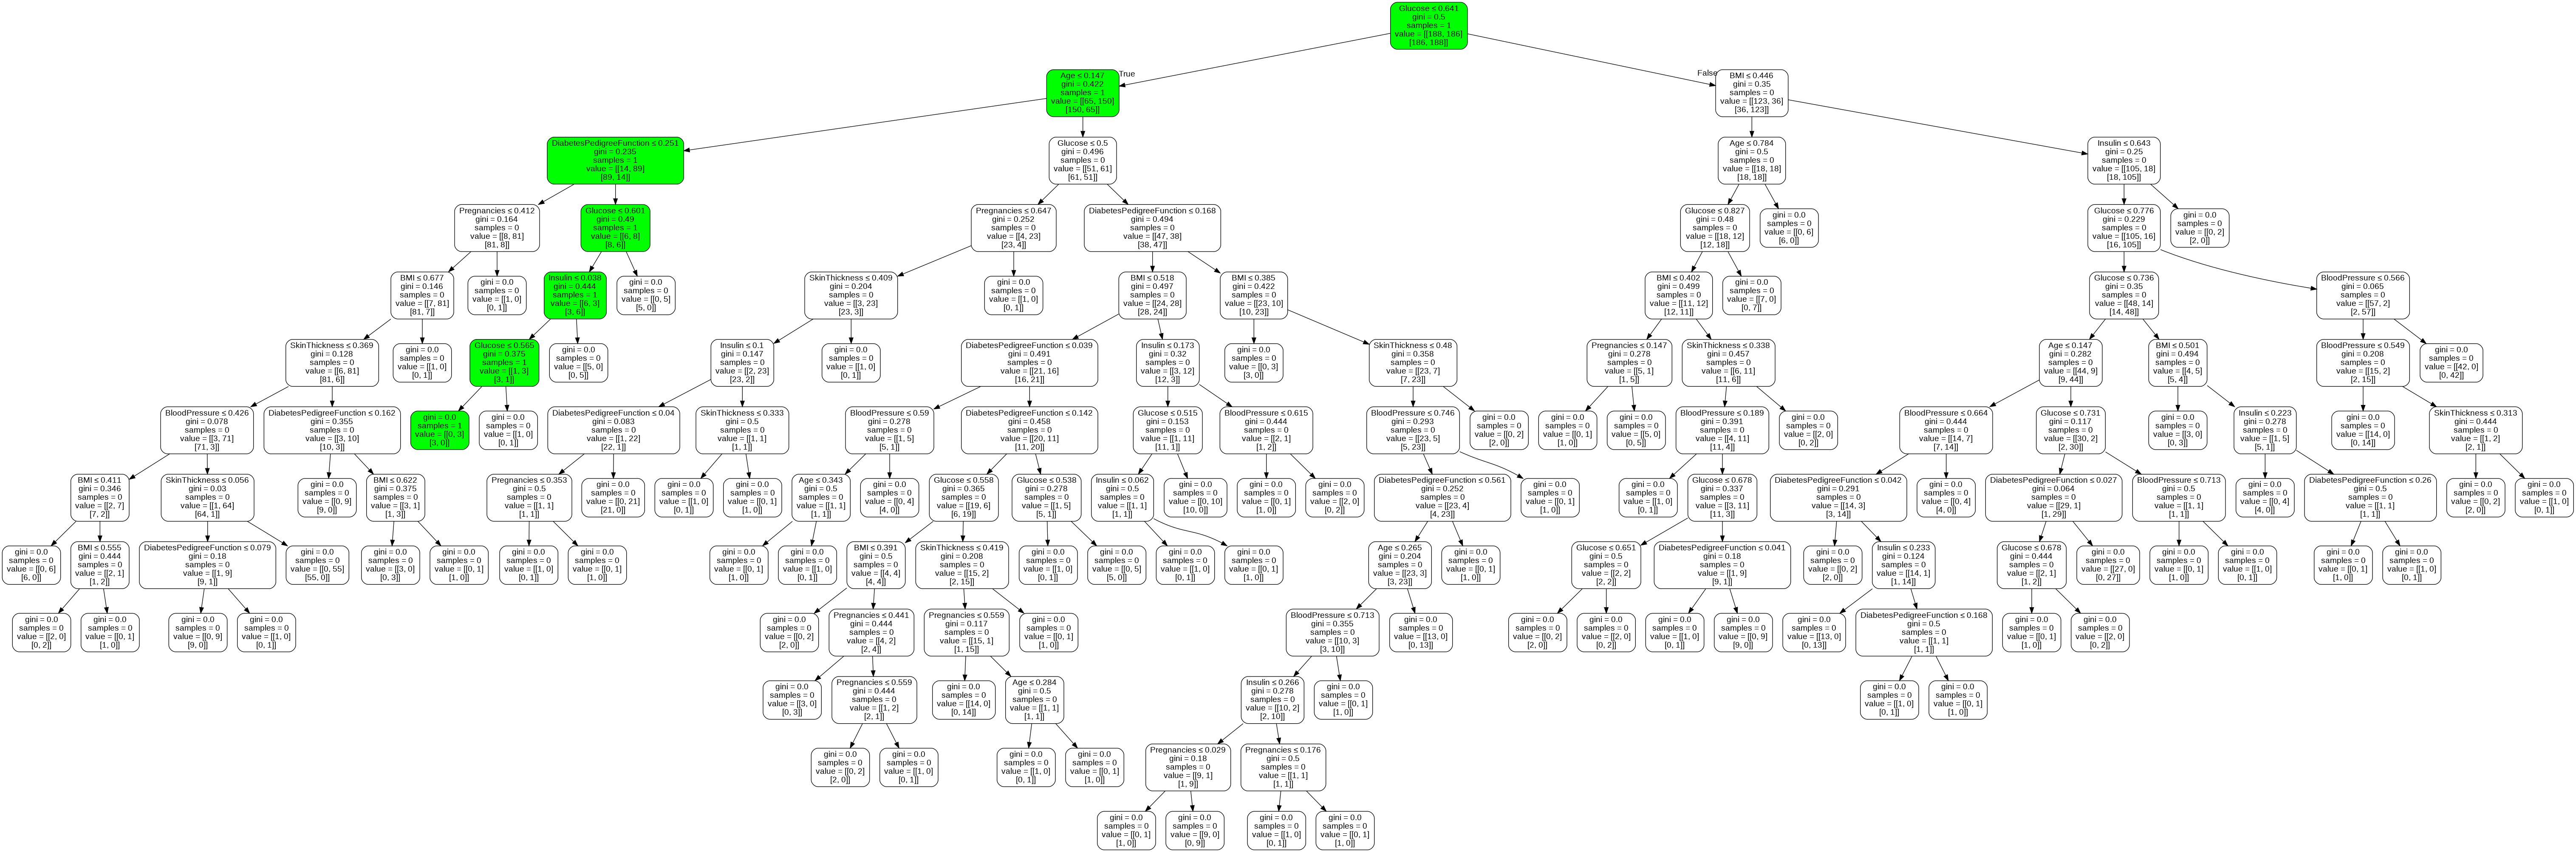

In [ ]:
filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
img = visualize_decision_tree_path( clf, graph, instance, INDX, 'true_negatives', filepath )
img

In [ ]:
[bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, class_var, 
                                                                       encoder, scaler, clf,  PATH + 'Whitebox_Model/' , 
                                                                       DATASET_NAME, variance = VAR)

inference = gnb.getInference(bn, evs={  },targets=feature_names_cp )
gnb.sideBySide(*[inference, markov_blanket, infoBN ], captions=[ "Inference", "Markov Blanket", "Information BN" ])


Selecting Greedy Hill Climbing Algorithm


#### Check fidelity

In [ ]:
 mb_lst, dt_lst, fid = check_fidelity(bn, markov_blanket, tree_path, verbose = 0 )
 print("%.2f%%" %(fid))

50.00%


### Example of False Positive

In [ ]:

exp_type = "false_positives"
INDX = 1
instance = false_positives[INDX]

# get the decision path that explains the instance
tree_path = extract_decision_path(clf, graph, instance )
tree_path

[['<Glucose &le; 0.641', 'value = [[188, 186]', '[186, 188]]>'],
 ['<Age &le; 0.147', 'value = [[65, 150]', '[150, 65]]>'],
 ['<DiabetesPedigreeFunction &le; 0.251', 'value = [[14, 89]', '[89, 14]]>'],
 ['<Pregnancies &le; 0.412', 'samples = 0', 'value = [[8, 81]', '[81, 8]]>'],
 ['<BMI &le; 0.677', 'samples = 0', 'value = [[7, 81]', '[81, 7]]>'],
 ['<SkinThickness &le; 0.369', 'samples = 0', 'value = [[6, 81]', '[81, 6]]>'],
 ['<BloodPressure &le; 0.426', 'samples = 0', 'value = [[3, 71]', '[71, 3]]>'],
 ['<BMI &le; 0.411', 'samples = 0', 'value = [[2, 7]', '[7, 2]]>'],
 ['<BMI &le; 0.555', 'samples = 0', 'value = [[2, 1]', '[1, 2]]>'],
 ['<gini = 0.0', 'value = [[2, 0]', '[0, 2]]>']]

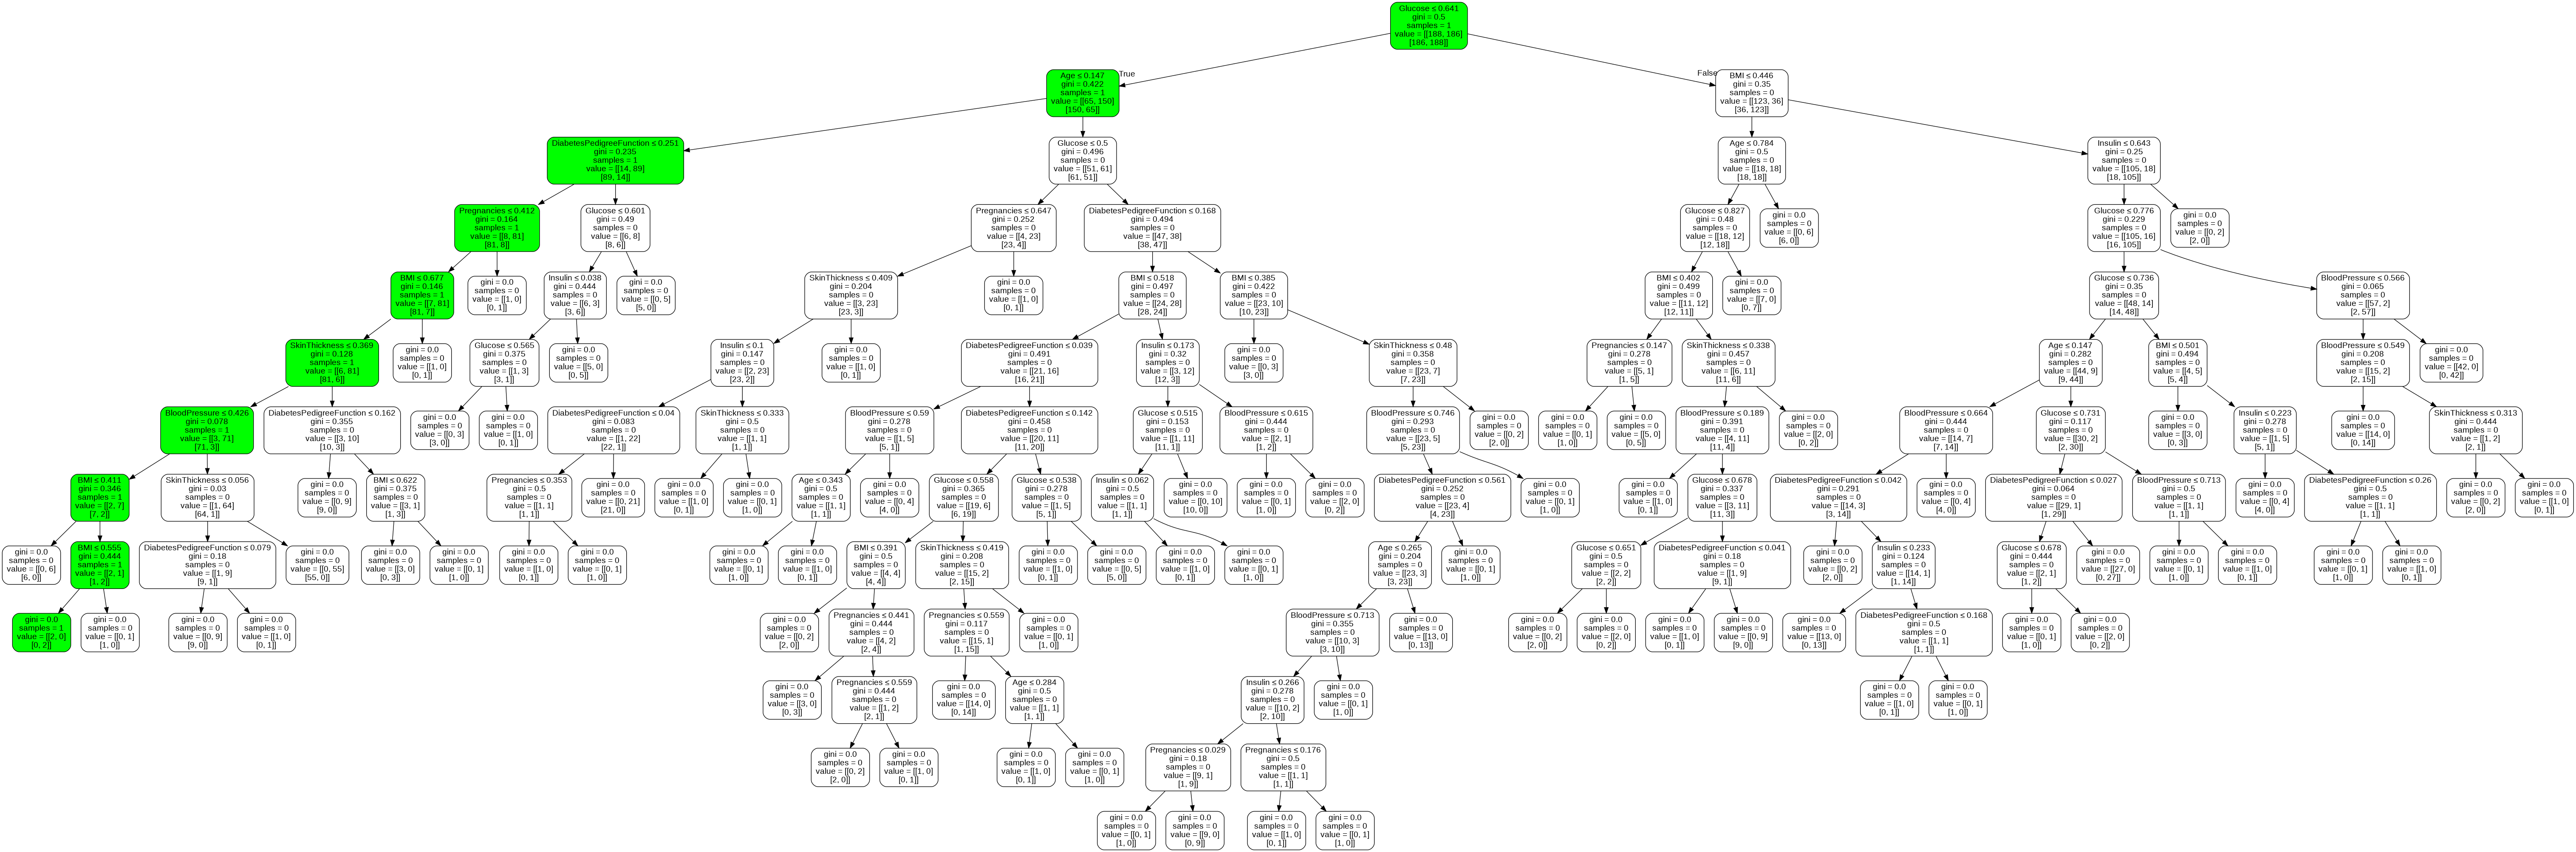

In [ ]:
filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
img = visualize_decision_tree_path( clf, graph, instance, INDX, 'false_positives', filepath )
img

In [ ]:
[bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, class_var, 
                                                                       encoder, scaler, clf,  PATH + 'Whitebox_Model/' , 
                                                                       DATASET_NAME, variance = VAR)

inference = gnb.getInference(bn, evs={  },targets=feature_names_cp )
gnb.sideBySide(*[inference, markov_blanket, infoBN ], captions=[ "Inference", "Markov Blanket", "Information BN" ])


Selecting Greedy Hill Climbing Algorithm


#### Check Fidelity


In [ ]:
 mb_lst, dt_lst, fid = check_fidelity(bn, markov_blanket, tree_path, verbose = 0 )
 print("%.2f%%" %(fid))

71.43%


### False Negative


In [ ]:
INDX = 4
instance = false_negatives[INDX]

# get the decision path that explains the instance
tree_path = extract_decision_path(clf, graph, instance )
tree_path

[['<Glucose &le; 0.641', 'value = [[188, 186]', '[186, 188]]>'],
 ['<BMI &le; 0.446', 'samples = 0', 'value = [[123, 36]', '[36, 123]]>'],
 ['<Age &le; 0.784', 'samples = 0', 'value = [[18, 18]', '[18, 18]]>'],
 ['<Glucose &le; 0.827', 'samples = 0', 'value = [[18, 12]', '[12, 18]]>'],
 ['<BMI &le; 0.402', 'samples = 0', 'value = [[11, 12]', '[12, 11]]>'],
 ['<Pregnancies &le; 0.147', 'samples = 0', 'value = [[5, 1]', '[1, 5]]>'],
 ['<gini = 0.0', 'value = [[0, 1]', '[1, 0]]>']]

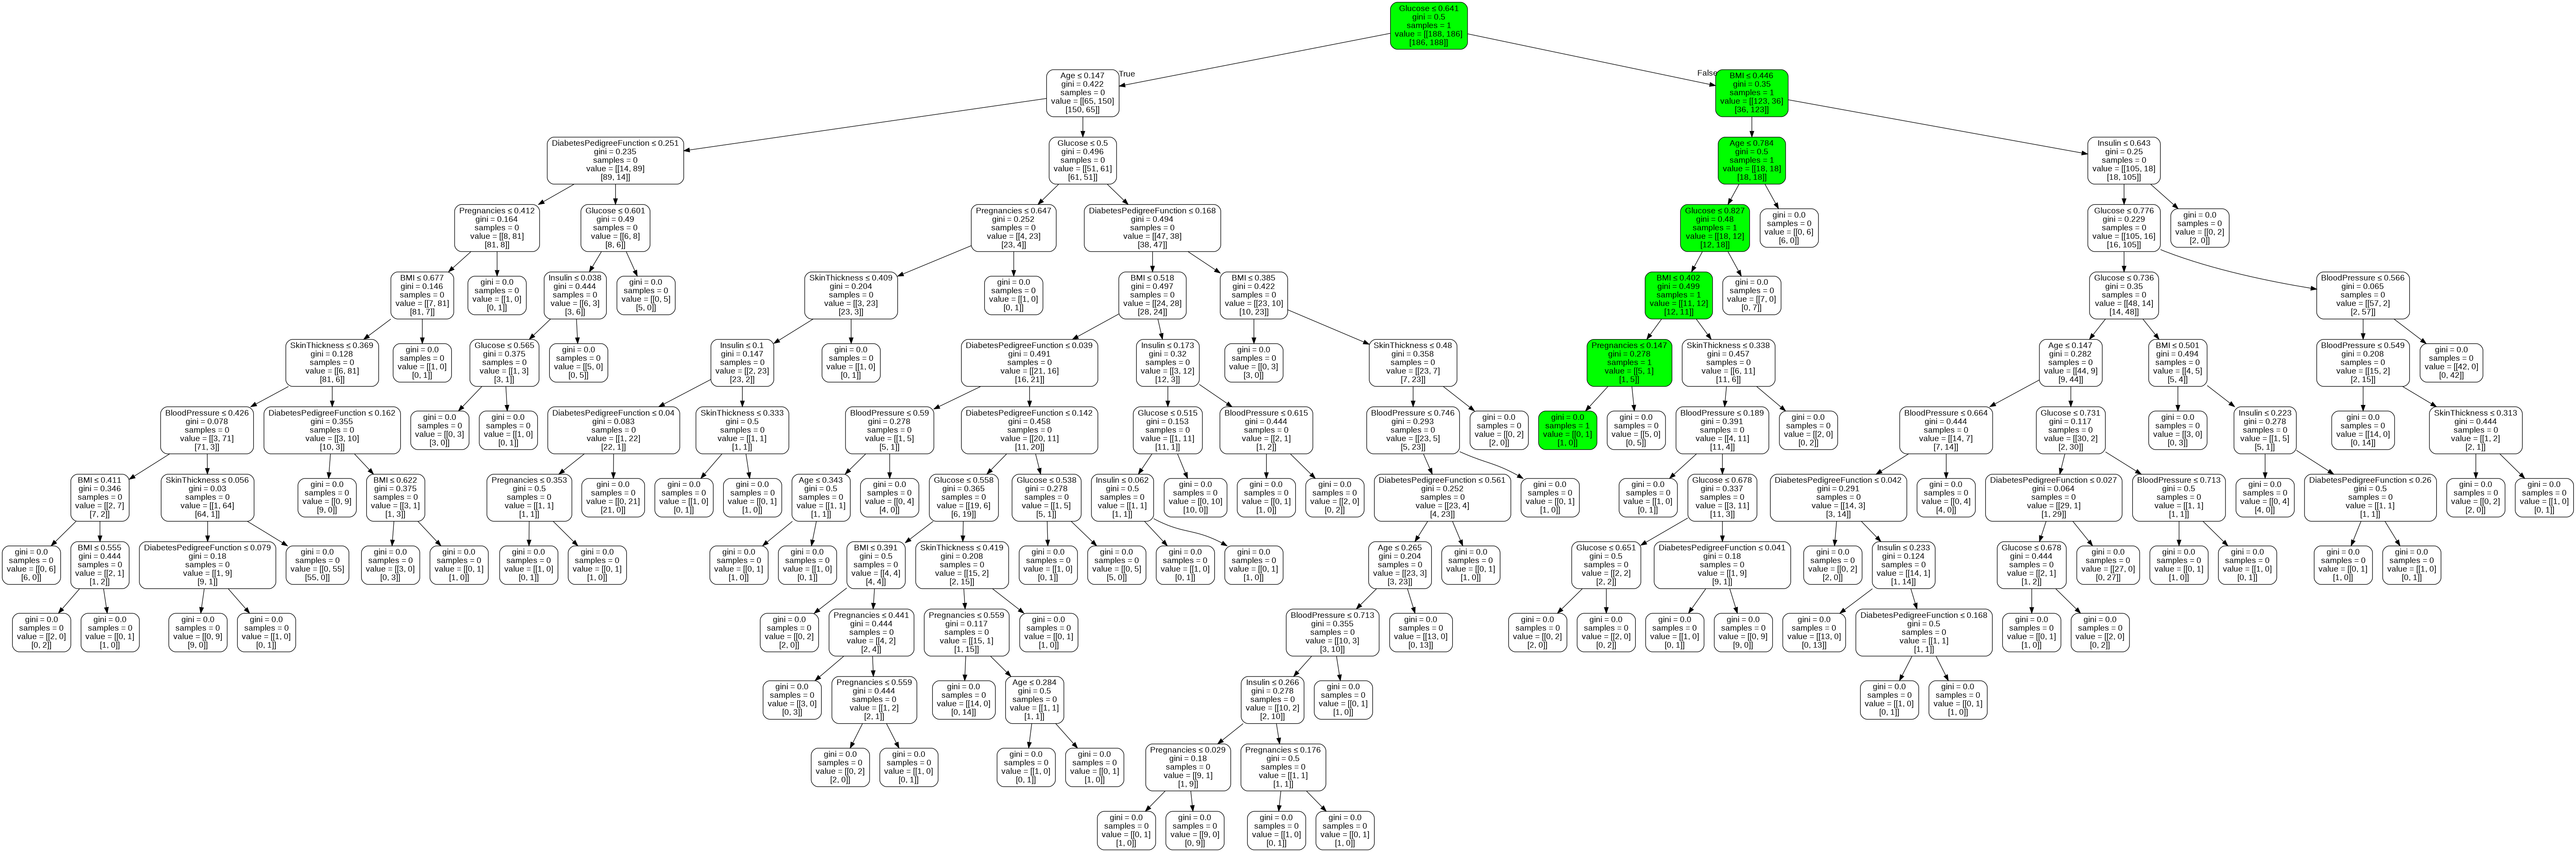

In [ ]:
filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
img = visualize_decision_tree_path( clf, graph, instance, INDX, 'false_negatives', filepath )
img

In [ ]:
INDX = 4
instance = false_negatives[INDX]
[bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, class_var, 
                                                                       encoder, scaler, clf,  PATH + 'Whitebox_Model/' , 
                                                                       DATASET_NAME, variance = VAR)

inference = gnb.getInference(bn, evs={  },targets=feature_names_cp )
gnb.sideBySide(*[inference, markov_blanket, infoBN ], captions=[ "Inference", "Markov Blanket", "Information BN" ])


Selecting Greedy Hill Climbing Algorithm


#### Check Fidelity

In [ ]:
mb_lst, dt_lst, fid = check_fidelity(bn, markov_blanket, tree_path, verbose = 0 )
print("%.2f%%" %(fid))

25.00%


### Generating Explanations for True Positives in Whitebox Model


In [ ]:
VAR = 0.1
INDX = 0
fidelity_lst = []
exp_type = "true_positives"
results_path = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type +"/"+ exp_type + ".csv"
print(results_path)
with open(results_path, "w") as results_file:

  results_file.write("INDX\tDecision Tree\tMarkov Blanket\tFidelity\n")
  for instance in true_positives:
    print("INDEX = (%d, %d)" %((instance['index'], INDX) ))

    # get the decision path that explains the instance
    tree_path = extract_decision_path(clf, graph, instance )
    filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
    img = visualize_decision_tree_path( clf, graph, instance, INDX, exp_type, filepath )

    # get the Bayesian network that explains the instance
    [bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, class_var, 
                                                                         encoder, scaler, clf, PATH + "Whitebox_Model/", DATASET_NAME, variance = VAR)      
    gnb.sideBySide(*[inference, markov_blanket, infoBN ], captions=[ "Inference", "Markov Blanket", "Information BN" ])
    print(" \n\n\n")

    # compute fidelity: len(nodes(markov_blanket) intersect nodes(decision_tree)) / len(nodes(decision_tree))
    mb_lst, dt_lst, fid = check_fidelity(bn, markov_blanket, tree_path, verbose = 1 )
    
    # convert list of nodes to string
    mb_lst = ' '.join([str(elem) for elem in mb_lst])
    dt_lst = ' '.join([str(elem) for elem in dt_lst])

    # write results to file
    results_file.write( str(INDX) + "\t" +  dt_lst + "\t" + mb_lst + "\t" + str(fid) + "\n" )
    INDX = INDX + 1

  results_file.close()

/content/drive/My Drive/Colab Notebooks/DDS/Whitebox_Model/explanations/diabetes/Decision_Tree/true_positives/true_positives.csv
INDEX = (1, 0)
Selecting Greedy Hill Climbing Algorithm


 



Markov Blanket:
{'Pregnancies'}
Decision Tree:
{'Glucose', 'BMI', 'BloodPressure', 'Insulin'}
INDEX = (3, 1)
Selecting Greedy Hill Climbing Algorithm


 



Markov Blanket:
{'BloodPressure', 'Age', 'Pregnancies', 'Insulin'}
Decision Tree:
{'Glucose', 'BMI', 'BloodPressure', 'Insulin'}
INDEX = (5, 2)


KeyboardInterrupt: ignored

In [ ]:
# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, indx, exp_type, path ):  

  for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

  samples = instance['scaled_vector']
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  filename = path
  graph.write_png(filename)

  im = PIL.Image.open(filename)
  return im

# EXPORT_DECISION_TREE
# 
def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph

# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  samples = instance['scaled_vector']
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

# GET_DECISION_TREE_FEAT
# 
def get_decision_tree_feat(tree_path):
  features = []
  for feat in tree_path:
    features.append( feat[0].split(" ")[0].replace("<","") )
  
  features.remove("gini")
  features = set(features)
  return features

def getNodeMap( bn ):
  dict_bn = {}
  for n in bn.names():
    dict_bn[bn.idFromName(n)] = n
  return dict_bn

def check_fidelity(bn, markov_blanket, tree_path, verbose = 0 ):
  
  mb_lst = []
  for i in markov_blanket.nodes():
    if getNodeMap(bn)[i] != 'Diabetes?':
      mb_lst.append(getNodeMap(bn)[i])
  
  mb_lst = set(mb_lst)
  dt_lst = get_decision_tree_feat( tree_path )
  if verbose == 1:
    print("Markov Blanket:")
    print(mb_lst )
    print("Decision Tree:")
    print(dt_lst  )

  return mb_lst, dt_lst, (len(mb_lst & dt_lst) / len(dt_lst))*100


#### Evaluate Rules in Test Set

In [ ]:
class_var = "Diabetes?"
generate_rule_stats( class_var, true_positives, VAR=0.1, label="Yes")


Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy

#### Evaluate Rules for Training Set

In [ ]:

generate_rule_stats( class_var, true_positives_train, VAR=0.1, label="Yes")


Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy

### Generating Explanations for False Positives in Whitebox Model

In [ ]:
INDX = 0
fidelity_lst = []
exp_type = "false_positives"
results_path = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type +"/"+ exp_type + ".csv"
print(results_path)
with open(results_path, "w") as results_file:

  results_file.write("INDX\tDecision Tree\tMarkov Blanket\tFidelity\n")
  for instance in false_positives:
    print("INDEX = (%d, %d)" %((instance['index'], INDX) ))

    # get the decision path that explains the instance
    tree_path = extract_decision_path(clf, graph, instance )
    filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
    img = visualize_decision_tree_path( clf, graph, instance, INDX, exp_type, filepath )

    # get the Bayesian network that explains the instance
    [bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, class_var, 
                                                                         encoder, scaler, clf, PATH + "Whitebox_Model/", DATASET_NAME, variance = VAR)      
    gnb.sideBySide(*[inference, markov_blanket, infoBN ], captions=[ "Inference", "Markov Blanket", "Information BN" ])
    print(" \n\n\n")

    # compute fidelity: len(nodes(markov_blanket) intersect nodes(decision_tree)) / len(nodes(decision_tree))
    mb_lst, dt_lst, fid = check_fidelity(bn, markov_blanket, tree_path, verbose = 1 )
    
    # convert list of nodes to string
    mb_lst = ' '.join([str(elem) for elem in mb_lst])
    dt_lst = ' '.join([str(elem) for elem in dt_lst])

    # write results to file
    results_file.write( str(INDX) + "\t" +  dt_lst + "\t" + mb_lst + "\t" + str(fid) + "\n" )
    INDX = INDX + 1

  results_file.close()

#### Evaluate Rules for Test Set

In [ ]:

generate_rule_stats( class_var, false_positives, VAR=0.1, label="Yes")


Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
[8, 0, 5, 3]
[0.5, 0.0, 0.3125, 0.1875]


#### Evaluate Rules for Training Set

In [ ]:

generate_rule_stats( class_var, false_positives_train, VAR=0.1, label="Yes")


[0, 0, 0, 0]


ZeroDivisionError: ignored

### Generating Explanations for False Negatives in Whitebox Model

In [ ]:

INDX = 0
fidelity_lst = []
exp_type = "false_negatives"
results_path = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type +"/"+ exp_type + ".csv"
print(results_path)
with open(results_path, "w") as results_file:

  results_file.write("INDX\tDecision Tree\tMarkov Blanket\tFidelity\n")
  for instance in false_negatives:
    print("INDEX = (%d, %d)" %((instance['index'], INDX) ))

    # get the decision path that explains the instance
    tree_path = extract_decision_path(clf, graph, instance )
    filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
    img = visualize_decision_tree_path( clf, graph, instance, INDX, exp_type, filepath )

    # get the Bayesian network that explains the instance
    [bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, class_var, 
                                                                         encoder, scaler, clf, PATH + "Whitebox_Model/", DATASET_NAME, variance = VAR)      
    gnb.sideBySide(*[inference, markov_blanket, infoBN ], captions=[ "Inference", "Markov Blanket", "Information BN" ])
    print(" \n\n\n")

    # compute fidelity: len(nodes(markov_blanket) intersect nodes(decision_tree)) / len(nodes(decision_tree))
    mb_lst, dt_lst, fid = check_fidelity(bn, markov_blanket, tree_path, verbose = 1 )
    
    # convert list of nodes to string
    mb_lst = ' '.join([str(elem) for elem in mb_lst])
    dt_lst = ' '.join([str(elem) for elem in dt_lst])

    # write results to file
    results_file.write( str(INDX) + "\t" +  dt_lst + "\t" + mb_lst + "\t" + str(fid) + "\n" )
    INDX = INDX + 1

  results_file.close()

#### Evaluate Rules for Test Set

In [ ]:

generate_rule_stats( class_var, false_negatives, VAR=0.05, label="No")


Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
[1, 0, 8, 6]
[0.06666666666666667, 0.0, 0.5333333333333333, 0.4]


#### Evaluate Rules for Training Set

In [ ]:

generate_rule_stats( class_var, false_negatives_train, VAR=0.1, label="No")


[0, 0, 0, 0]


ZeroDivisionError: ignored

### Generating Explanations for True Negatives in Whitebox Model

In [ ]:

INDX = 0
fidelity_lst = []
exp_type = "true_negatives"
results_path = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type +"/"+ exp_type + ".csv"
print(results_path)
with open(results_path, "w") as results_file:

  results_file.write("INDX\tDecision Tree\tMarkov Blanket\tFidelity\n")
  for instance in true_negatives:
    print("INDEX = (%d, %d)" %((instance['index'], INDX) ))

    # get the decision path that explains the instance
    tree_path = extract_decision_path(clf, graph, instance )
    filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
    img = visualize_decision_tree_path( clf, graph, instance, INDX, exp_type, filepath )

    # get the Bayesian network that explains the instance
    [bn, inference, infoBN, markov_blanket] = generate_BN_explanationsMB(instance, label_lst, feature_names, class_var, 
                                                                         encoder, scaler, clf, PATH + "Whitebox_Model/", DATASET_NAME, variance = VAR)      
    gnb.sideBySide(*[inference, markov_blanket, infoBN ], captions=[ "Inference", "Markov Blanket", "Information BN" ])
    print(" \n\n\n")

    # compute fidelity: len(nodes(markov_blanket) intersect nodes(decision_tree)) / len(nodes(decision_tree))
    mb_lst, dt_lst, fid = check_fidelity(bn, markov_blanket, tree_path, verbose = 1 )
    
    # convert list of nodes to string
    mb_lst = ' '.join([str(elem) for elem in mb_lst])
    dt_lst = ' '.join([str(elem) for elem in dt_lst])

    # write results to file
    results_file.write( str(INDX) + "\t" +  dt_lst + "\t" + mb_lst + "\t" + str(fid) + "\n" )
    INDX = INDX + 1

  results_file.close()

#### Evaluate Rules for Test Set

In [ ]:

generate_rule_stats( class_var, true_negatives, VAR=0.05, label="No")



Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy

#### Evaluate Rules for Training Set

In [ ]:

generate_rule_stats( class_var, true_negatives_train, VAR=0.05, label="No")


Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy Hill Climbing Algorithm
Selecting Greedy